## Do it! Natural Language Processing using BERT and GPT - part8
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 8. 문장 생성하기
### 8.1 문장 생성 모델 훑어보기

#### 문장 생성 : 문장을 만들어 내는 과제 / 컨텍스트가 주어졌을 때 다음 단어로 어떤 단어가 오는게 적절한지 분류

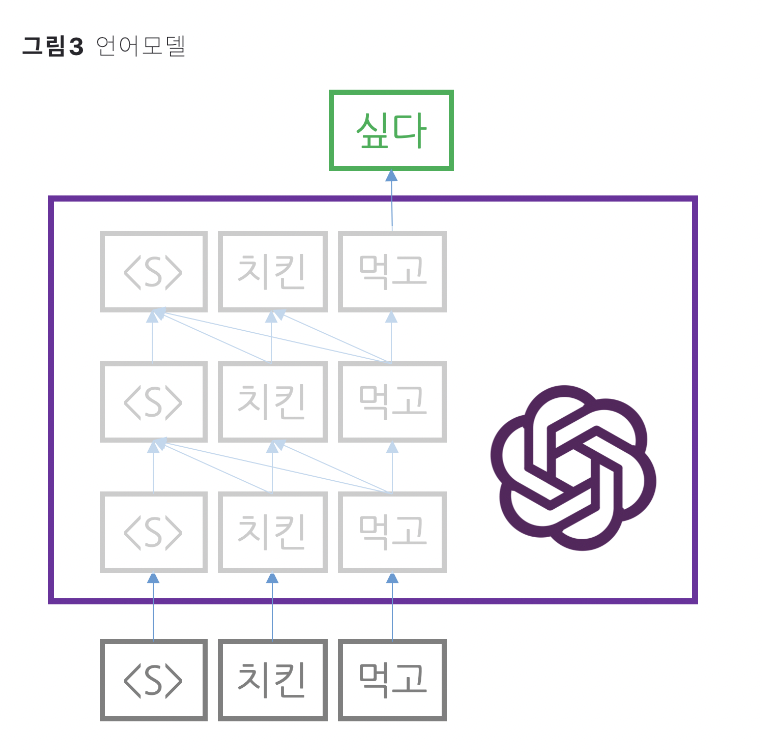
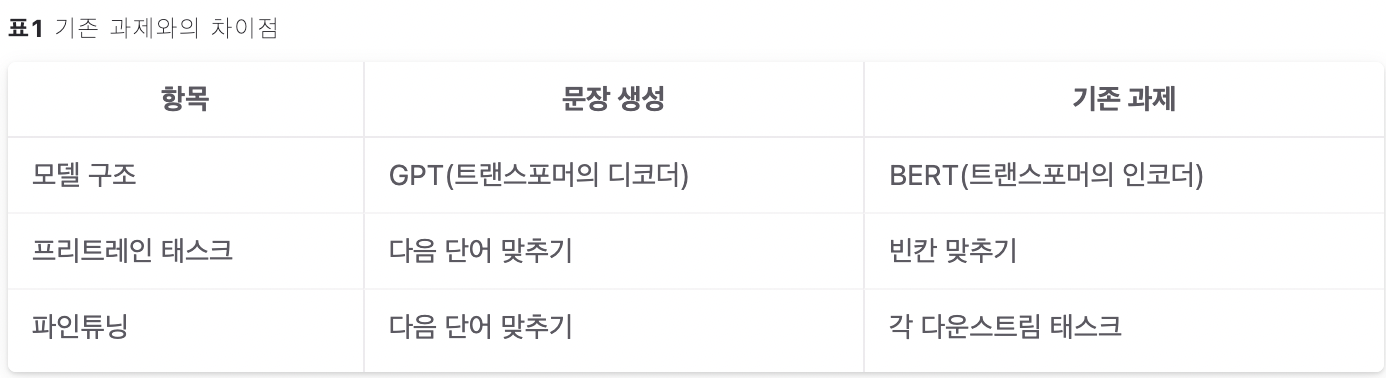

### 8.2 문장 생성 모델 파인튜닝하기

In [1]:
#### 모델 환경 설정
import torch
from ratsnlp.nlpbook.generation import GenerationTrainArguments
args = GenerationTrainArguments(pretrained_model_name = 'skt/kogpt2-base-v2',
                               downstream_corpus_name = 'nsmc',
                               downstream_model_dir= './part4-model',
                               max_seq_length=32,
                               batch_size=32 if torch.cuda.is_available() else 4,
                               learning_rate=5e-5,
                               epochs=3,
                               tpu_cores=0 if torch.cuda.is_available() else 8,
                               seed=7)

#### 랜덤 시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

#### 로거 설정
nlpbook.set_logger(args)

#### 말뭉치 다운로드
from Korpora import Korpora
Korpora.fetch(corpus_name=args.downstream_corpus_name,
             root_dir = args.downstream_corpus_root_dir,
             force_download=args.force_download)

#### 토크나이저 준비
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(args.pretrained_model_name,
                                                   eos_toke="</s>")

#### 데이터 전처리하기
from ratsnlp.nlpbook.generation import NsmcCorpus, GenerationDataset
corpus = NsmcCorpus()
train_dataset = GenerationDataset(args=args,
                                 corpus=corpus,
                                 tokenizer=tokenizer,
                                 mode='train')

#### 학습 데이터 로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(train_dataset,
                             batch_size=args.batch_size,
                             sampler=RandomSampler(train_dataset, replacement=False),
                             collate_fn=nlpbook.data_collator,
                             drop_last=False,
                             num_workers=args.cpu_workers)

#### 평가용 데이터 로더 구축
from torch.utils.data import SequentialSampler
val_dataset = GenerationDataset(args=args,
                               corpus=corpus,
                               tokenizer=tokenizer,
                               mode="test")
val_dataloader = DataLoader(val_dataset,
                           batch_size=args.batch_size,
                           sampler=SequentialSampler(val_dataset),
                           collate_fn=nlpbook.data_collator,
                           drop_last=False,
                           num_workers=args.cpu_workers)

#### 모델 초기화
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(args.pretrained_model_name)

#### 태스크 정의
from ratsnlp.nlpbook.generation import GenerationTask
task = GenerationTask(model, args)

#### 트레이너 정의
trainer = nlpbook.get_trainer(args)

#### 학습 개시
trainer.fit(task,
           train_dataloader=train_dataloader,
           val_dataloaders=val_dataloader)

SyntaxError: invalid syntax (<ipython-input-1-4323187a44a0>, line 30)

### 8.3 프리트레인 마친 모델로 문장 생성하기


In [2]:
#### 체크포인트 로드
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
model.eval()

#### 토크나이저 로드
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2',
                                                   eos_token='</s>')

#### 모델 입력값 만들기
input_ids = tokenizer.encode('안녕하세요', return_tensors='pt')

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
#### 그리디 서치 
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                 do_sample=False,
                                 min_length=10,
                                 max_length=50)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 빔 서치 
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=False,
                                   min_length=10,
                                   max_length=50,
                                   num_beams=3)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 반복 줄이기 (1)
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=False,
                                   min_length=10,
                                   max_length=50,
                                   no_repeat_ngram_size=3)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 반복 줄이기 (2)
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=False,
                                   min_length=10,
                                   max_length=50,
                                   repetition_penalty=1.1)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 탑 k 샘플링 -> 모델이 예측한 다음 토큰 확률 분포에서 확률값이 가장 높은 k개 토큰 가운데 하나를 다음 토큰으로 선택
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=True,
                                   min_length=10,
                                   max_length=50,
                                   top_k=50)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 템퍼레처 스케일링 -> 모델의 다음 토큰 확률 분포를 대소 관계의 역전 없이 분포의 모양만을 바꿔서 문장을 다양하게 생성
#### temperature가 1보다 작으면 정확한 문장, 1보다 크면 다양한 문장 생성
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=True,
                                   min_length=10,
                                   max_length=50,
                                   top_k=50,
                                   temperature=0.01)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))

In [ ]:
#### 탑 p 샘플링(뉴클리어스 샘플링) -> 확률값이 높은 순서대로 내림차순 정렬한 뒤 누적 확률값이 p 이상인 최소 개수의 토큰 집합 가운데 하나를 다음 토큰으로 선택
import torch
with torch.no_grad():
    generated_ids = model.generate(input_ids,
                                   do_sample=True,
                                   min_length=10,
                                   max_length=50,
                                   top_p=0.92)
    
#### 토큰 인덱스를 문장으로 복원하기
print(tokenizer.decode([el.item() for el in generated_ids[0]]))